In [53]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# Cell magic method always stays at the top of the cell

# Imports from the Python standard library should be at the top
import os
import copy
import pickle
import itertools 

# Do not import * unless you know what you are doing
import numpy as np 
import pandas as pd

import fsps
import sedpy
import lineid_plot

from sedpy.observate import getSED, vac2air, air2vac

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)

import astropy.units as u
from astropy.io import ascii
from astropy.table import Table, Column
from astropy.constants import c, L_sun, pc
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import equivalent_width

from prospect import models

# re-defining plotting defaults
from matplotlib import rcParams

from dwarf_models import SDSS_EMLINES, simulate_dwarf_sed, test_single_model,\
    sigma_clipping_continuum, measure_ew_emission_line, design_model_grid,\
    generate_dwarf_population, measure_color_ew, plot_models_with_sdss, setup_fsps_spop

rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 22})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Start a FSPS model

In [2]:
sp = fsps.StellarPopulation(zcontinuous=1)

_ = sp.get_spectrum()
_ = sp.get_mags()

print(sp.libraries)

# These are the parameters that you can modify
print(sp.params.all_params)

fsps_emline_wave = sp.emline_wavelengths

# Metallicity range for MIST
# -2.50 -2.00 -1.75 -1.50 -1.25 -1.00 -0.75 -0.50 -0.25 +0.00 +0.25 +0.5
sdss_bands = fsps.find_filter('SDSS')

model_default = {
    'dust1': 0.5, 'dust2': 0.0,
    'logzsol': -1.0, 'gas_logz': -1.5, 'gas_logu': -3.0,
    'const': 0.5, 'tau': 0.5, 'tage': 10.0,
    'sf_trunc': 0.0, 'fburst': 0.0, 'tburst': 4.0,
}

(b'mist', b'miles')
['imf_type', 'imf_upper_limit', 'imf_lower_limit', 'imf1', 'imf2', 'imf3', 'vdmc', 'mdave', 'dell', 'delt', 'sbss', 'fbhb', 'pagb', 'add_stellar_remnants', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'redgb', 'agb', 'masscut', 'fcstar', 'evtype', 'smooth_lsf', 'smooth_velocity', 'redshift_colors', 'compute_light_ages', 'nebemlineinspec', 'dust_type', 'add_dust_emission', 'add_neb_emission', 'add_neb_continuum', 'cloudy_dust', 'add_igm_absorption', 'zmet', 'sfh', 'wgp1', 'wgp2', 'wgp3', 'tau', 'const', 'tage', 'fburst', 'tburst', 'dust1', 'dust2', 'logzsol', 'zred', 'pmetals', 'dust_clumps', 'frac_nodust', 'dust_index', 'dust_tesc', 'frac_obrun', 'uvb', 'mwr', 'dust1_index', 'sf_start', 'sf_trunc', 'sf_slope', 'duste_gamma', 'duste_umin', 'duste_qpah', 'sigma_smooth', 'min_wave_smooth', 'max_wave_smooth', 'gas_logu', 'gas_logz', 'igm_factor', 'fagn', 'agn_tau']


### Read in the SDSS catalog

In [16]:
sdss_cat = Table.read('/Users/runquanguan/Documents/Dwarf_SDSS_8_9_SF_v2.0.fits')

em_flag = (np.isfinite(sdss_cat['M_u']) & np.isfinite(sdss_cat['M_r']) & \
           np.isfinite(sdss_cat['M_g']) & np.isfinite(sdss_cat['M_i']) &\
           np.isfinite(sdss_cat['OIII_5007_EQW']) & \
           np.isfinite(sdss_cat['H_ALPHA_EQW']) &\
           np.isfinite(sdss_cat['H_BETA_EQW']))

sdss_use = sdss_cat[em_flag]


SDSS_EMLINES = {\
    'OII_3726': {'cen':3726.032, 'low':3717.0, 'upp':3737.0},\
    'OII_3729': {'cen':3728.815, 'low':3717.0, 'upp':3737.0},\
    'NeIII_3869': {'cen':3869.060, 'low':3859.0, 'upp':3879.0}, \
    'H_delta': {'cen':4101.734, 'low':4092.0, 'upp':4111.0},\
    'H_gamma': {'cen':4340.464, 'low':4330.0, 'upp':4350.0},\
    'OIII_4363': {'cen':4363.210, 'low':4350.0, 'upp':4378.0},\
    'H_beta': {'cen':4861.325, 'low':4851.0, 'upp':4871.0},\
    'OIII_4959': {'cen':4958.911, 'low':4949.0, 'upp':4969.0},\
    'OIII_5007': {'cen':5006.843, 'low':4997.0, 'upp':5017.0},\
    'HeI_5876': {'cen':5875.67, 'low':5866.0, 'upp':5886.0},\
    'OI_6300': {'cen':6300.304, 'low':6290.0, 'upp':6310.0},\
    'NII_6548': {'cen':6548.040, 'low':6533.0, 'upp':6553.0},\
    'H_alpha': {'cen':6562.800, 'low':6553.0, 'upp':6573.0},\
    'NII_6584': {'cen':6583.460, 'low':6573.0, 'upp':6593.0},\
    'SII_6717': {'cen':6716.440, 'low':6704.0, 'upp':6724.0},\
    'SII_6731': {'cen':6730.810, 'low':6724.0, 'upp':6744.0},\
    'ArIII7135': {'cen':7135.8, 'low':7130.0, 'upp':7140.0}
}


In [17]:
spop = setup_fsps_spop(sfh=1, imf_type=1, zcontinuous=1)

In [5]:
# One spectrum, no SED, per Hz
model_test = simulate_dwarf_sed(model_default, \
                                        spop, wave_min=3700, \
                                        wave_max=7400, filters=None, \
                                        spec_no_emline=False, peraa=False)

In [6]:
# One spectrum, no SED, per Angstrom
model_test = simulate_dwarf_sed(\
    model_default, spop, wave_min=3700, \
    wave_max=7400, filters=None, spec_no_emline=False, peraa=True)

In [7]:
# One spectrum, with SED, per Angstrom
model_test = simulate_dwarf_sed(\
    model_default, spop, wave_min=3700, \
    wave_max=7400, filters=sdss_bands,\
    spec_no_emline=False, peraa=True)

In [8]:
# Two spectra, no SED, per Angstrom
model_test = simulate_dwarf_sed(\
    model_default, spop, wave_min=3700,\
    wave_max=7400, filters=None, spec_no_emline=True, peraa=True)

In [10]:
# Two spectra, with SED, per Angstrom
model_test = simulate_dwarf_sed(\
    model_default, spop, wave_min=3700, \
    wave_max=7400, filters=sdss_bands, spec_no_emline=True, peraa=True)

In [11]:
spop_tau = setup_fsps_spop(\
    zcontinuous=1, imf_type=1, sfh=1, dust_type=0, \
    dust_index=-1.3, dust1_index=-1.0)

# Model u-r color :   1.328
# Model u-g color :   0.986
# Model g-r color :   0.342
# Model EW(Halpha) :  35.591
# Model EW([OIII]) :  10.939
# Current stellar mass :  0.62130
# log(SFR) :  -10.637


/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:446: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:446: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:462: RuntimeWarning: divide by zero encountered in log10
  sdss_use['M_u'] - sdss_use['M_r'], np.log10(-1.0 * (sdss_use['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:462: RuntimeWarning: invalid value encountered in log10
  sdss_use['M_u'] - sdss_use['M_r'], np.log10(-1.0 * (sdss_use['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:478: RuntimeWarning: divide by

'\n* Increase dust 1: color becomes redder; all EWs become lower\n'

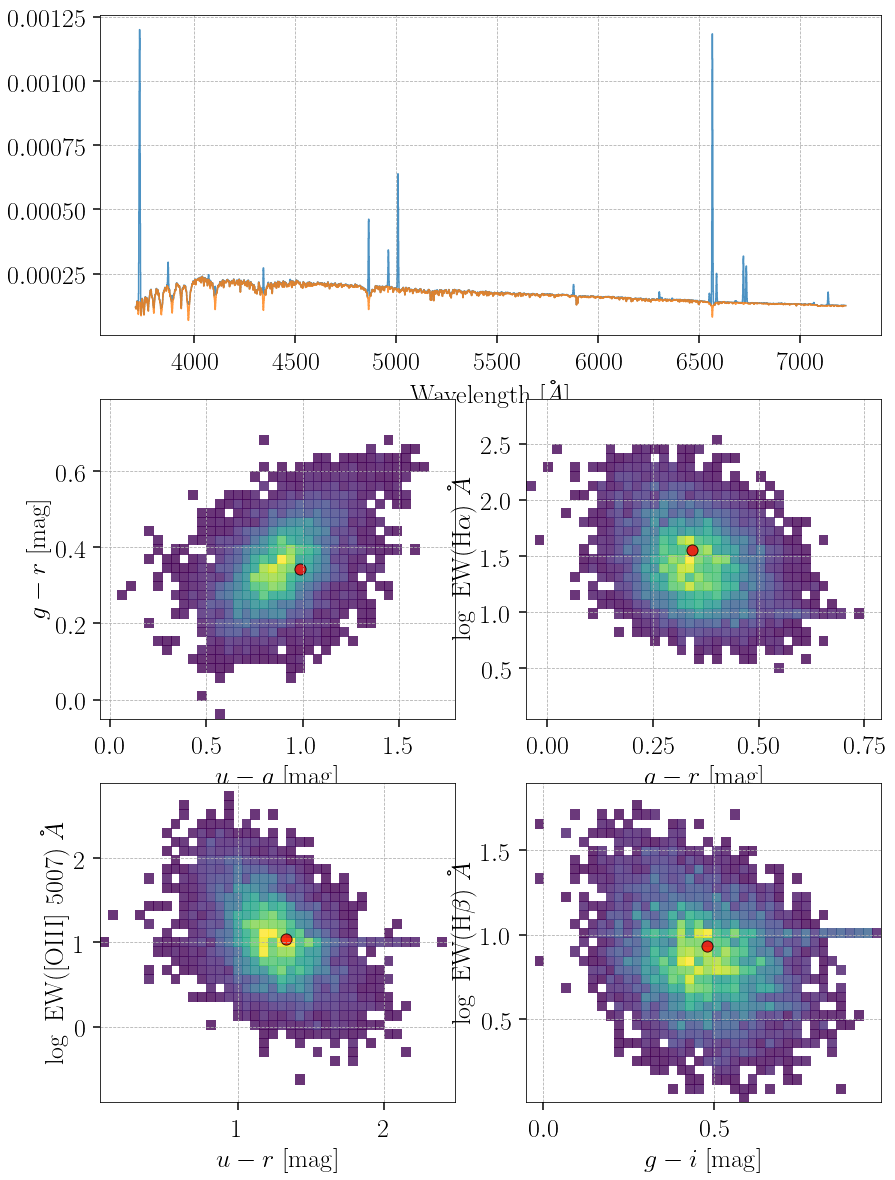

In [18]:
model_test = {\
    'dust1': 0.2, 'dust2': 0.0,\
    'logzsol': -0.8, 'gas_logz': -0.5, 'gas_logu': -3.2,\
    'const': 0.3, 'tau': 2.6, 'tage': 6.5,\
    'sf_trunc': 0.0, 'fburst': 0.60, 'tburst': 5.1,}

model, _ = test_single_model(\
    model_test, spop_tau, sdss_use, \
    wave_min=3700, wave_max=7400, em_list=SDSS_EMLINES)

"""
* Increase dust 1: color becomes redder; all EWs become lower
"""

## Generating a list of models

### Procedure to generate model

In [21]:
# Design the model grid
#   Just provide a list of allowed values for each parameter
dwarf_tau_grid = design_model_grid(
    tage=[4.0, 9.0], tau=[1.5, 5.0], 
    const=[0.0, 0.4], sf_trunc=None, 
    fburst=[0.0, 0.3], tburst=[2.0, 7.0],
    dust1=[0.0], dust2=[0.0], 
    logzsol=[-1.0, -0.3], gas_logz=[-1.5, -0.5], 
    gas_logu=[-3.5, -2.0])

print("# The default model grid has %d models" % len(dwarf_tau_grid))

# Initialize the spop model
print("# Initialize the FSPS model...will take a while...")
spop_tau = setup_fsps_spop(
    zcontinuous=1, imf_type=1, sfh=1, dust_type=0, 
    dust_index=-1.3, dust1_index=-1.0)

# Get the SDSS filters
sdss_bands = fsps.find_filter('SDSS')

print("# Done!")

# The default model grid has 256 models
# Initialize the FSPS model...will take a while...
# Done!


# Will use multi-processing with 10 cores!
# Model spectra are generated !


/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:744: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:744: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:760: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:760: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:776: RuntimeWarning: div

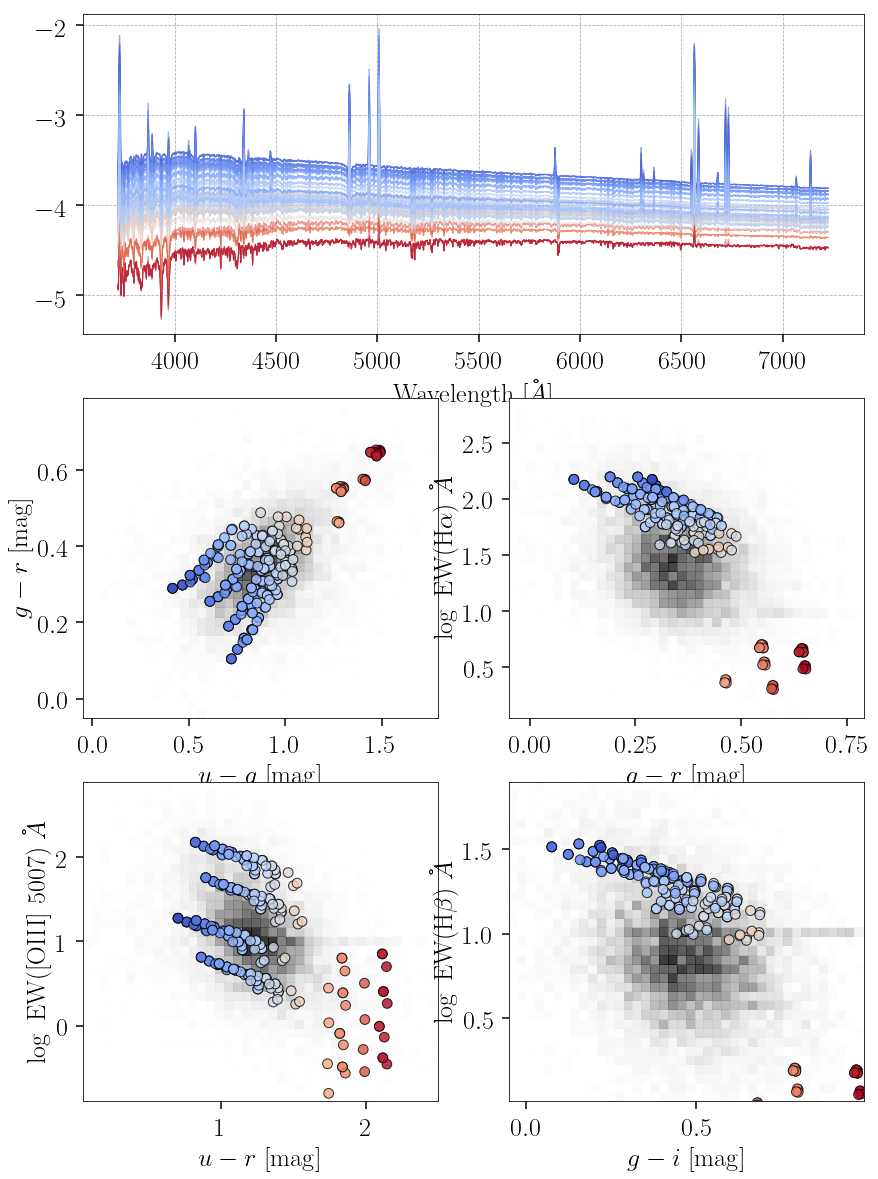

In [23]:
# Generate model spectra and seds
dwarf_models = generate_dwarf_population(
    spop_tau, dwarf_tau_grid, filters=sdss_bands, n_jobs=10)
print("# Model spectra are generated !")

# Measure colors and emission line EWs
# - SDSS_EMLINES is a pre-defined dict of emission lines center wavelength and the 
# wavelength window for measuring EW.
# - You can save the results in a numpy array
dwarf_models_table = measure_color_ew(
    dwarf_models, em_list=SDSS_EMLINES, output='dwarf_tau_test.npy')

# Make a summary plot
_ = plot_models_with_sdss(dwarf_models_table, sdss_use, wave_min=3720, wave_max=7225)

### Sampling priors of parameters to build a population

In [24]:
1 - 0.784541140796863  - 0.3860967606833913

-0.17063790148025432

In [106]:
from prospect.models import priors

# Gaussian distribution with boundary as prior for key parameters
tau_arr = [float(priors.ClippedNormal(mean=2.6, sigma=0.3, mini=1.0, maxi=8.0).sample()) for _ in range(4000)]
const_arr =  [float(priors.ClippedNormal(mean=0.3, sigma=0.1, mini=0.0, maxi=0.49).sample()) for _ in range(4000)]
tage_arr =  [float(priors.ClippedNormal(mean=6.5, sigma=0.3, mini=1.0, maxi=11.0).sample()) for _ in range(4000)]
fburst_arr =  [float(priors.ClippedNormal(mean=0.6, sigma=0.1, mini=0.0, maxi=0.8).sample()) for _ in range(4000)]
tburst_arr =  [float(priors.ClippedNormal(mean=5.0, sigma=0.5, mini=0.0, maxi=8.0).sample()) for _ in range(4000)]
logzsol_arr =  [float(priors.ClippedNormal(mean=-0.8, sigma=0.5, mini=-1.5, maxi=0.0).sample()) for _ in range(4000)]
gas_logz_arr =  [float(priors.ClippedNormal(mean=-0.5, sigma=0.5, mini=-1.5, maxi=0.0).sample()) for _ in range(4000)]
gas_logu_arr =  [float(priors.ClippedNormal(mean=-3.2, sigma=0.5, mini=-4.0, maxi=-1.0).sample()) for _ in range(4000)]

# Fix the fburst + const > 1 issue
for ii in np.arange(len(const_arr)):
    if const_arr[ii] + fburst_arr[ii] >= 0.95:
        f_over = (const_arr[ii] + fburst_arr[ii]) - 0.95
        if fburst_arr[ii] >= (f_over + 0.01):
            fburst_arr[ii] = fburst_arr[ii] - (f_over + 0.01)
        else:
            const_arr[ii] = const_arr[ii] - (f_over + 0.01)

# Fixed the rest
dust1_arr = np.full(4000, 0.1)
dust2_arr = np.full(4000, 0.0)
sf_trunc_arr = np.full(4000, 0.0)

# List of model parameters
dwarf_sample_parameters = [
     {
         'dust1': dust1_arr[ii], 
         'dust2': dust2_arr[ii],
         'logzsol': logzsol_arr[ii], 
         'gas_logz': gas_logz_arr[ii], 
         'gas_logu': gas_logu_arr[ii],
         'const': const_arr[ii], 
         'tau': tau_arr[ii], 
         'tage': tage_arr[ii],
         'sf_trunc': sf_trunc_arr[ii], 
         'fburst': fburst_arr[ii], 
         'tburst': tburst_arr[ii]
     } for ii in np.arange(4000)
]

# Double check
for ii, model in enumerate(dwarf_sample_parameters):
    if model['fburst'] + model['const'] >= 0.99:
        print(ii, model['fburst'], model['const'])

In [108]:
# Generate model spectra and seds
dwarf_sample_gaussian = generate_dwarf_population(
    spop_tau, dwarf_sample_parameters, filters=sdss_bands, n_jobs=14)

print("# Model spectra are generated !")

# Measure colors and emission line EWs
# - SDSS_EMLINES is a pre-defined dict of emission lines center wavelength and the 
# wavelength window for measuring EW.
# - You can save the results in a numpy array
dwarf_sample_table = measure_color_ew(
    dwarf_sample_gaussian, em_list=SDSS_EMLINES, output='dwarf_sample_gaussian_test.npy')

# Will use multi-processing with 14 cores!
# Model spectra are generated !


/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:744: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:744: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_g'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['H_ALPHA_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:760: RuntimeWarning: divide by zero encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:760: RuntimeWarning: invalid value encountered in log10
  sdss_data['M_u'] - sdss_data['M_r'], np.log10(-1.0 * (sdss_data['OIII_5007_EQW'])),
/Users/runquanguan/Documents/Research/hsc_massive/notebooks/dwarf/dwarf_models.py:776: RuntimeWarning: div

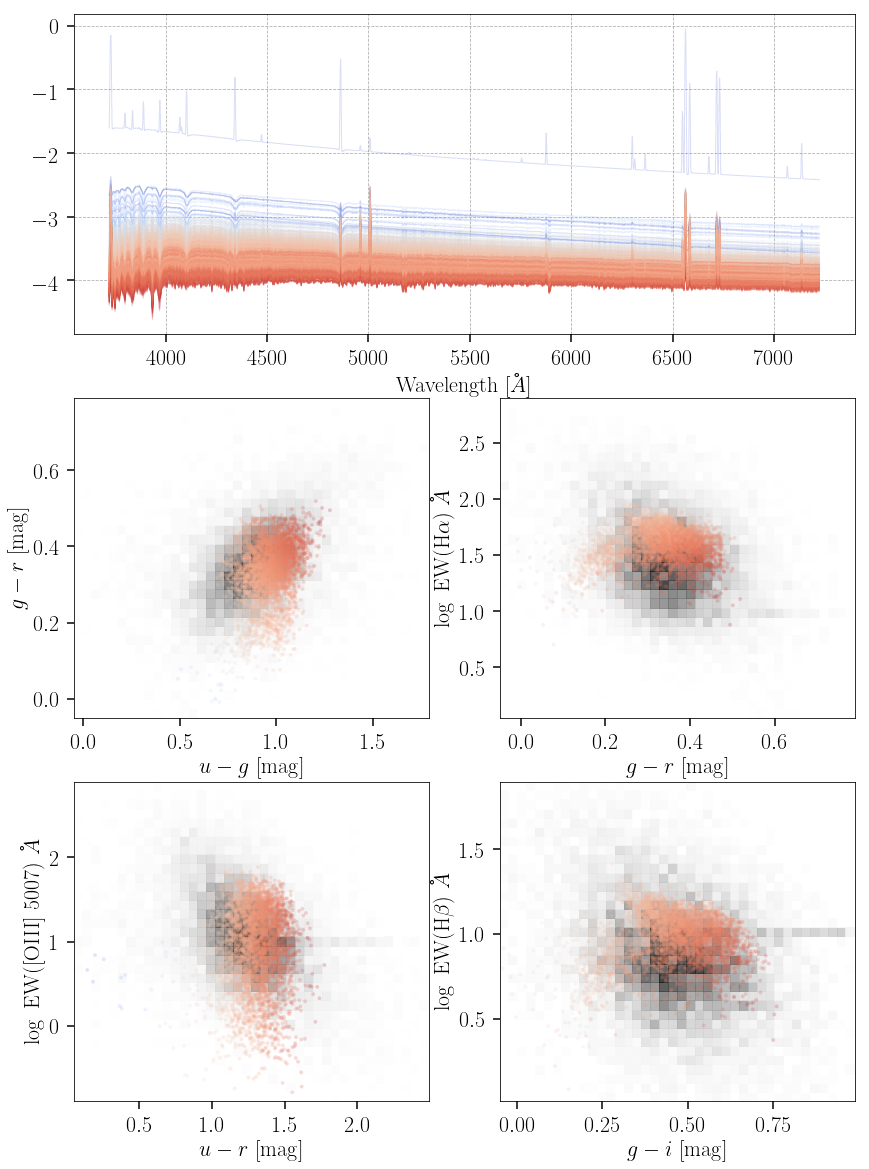

In [109]:
# Make a summary plot
_ = plot_models_with_sdss(
    dwarf_sample_table, sdss_use, wave_min=3720, wave_max=7225,
    size_symbol=15, alpha_spec=0.2, alpha_symbol=0.2, ecolor_symbol='none')

### Estimate the K-L divergence of two distributions

In [110]:
sdss_arr = np.stack(
    [np.asarray(sdss_use['M_u'] - sdss_use['M_g']), 
     np.asarray(sdss_use['M_g'] - sdss_use['M_i']),
     np.asarray(sdss_use['H_ALPHA_EQW']), 
     np.asarray(sdss_use['OIII_5007_EQW'])
    ])

model_arr = np.stack(
    [np.asarray(dwarf_models_table['ug_color']),
     np.asarray(dwarf_models_table['gi_color']),
     np.asarray(dwarf_models_table['ew_halpha']),
     np.asarray(dwarf_models_table['ew_oiii_5007'])
    ])

sdss_pdf, _ = np.histogramdd(sdss_arr.T, density=True)

model_pdf, _ = np.histogramdd(model_arr.T, density=True)

In [111]:
from scipy.stats import entropy

#entropy(sdss_pdf, model_pdf)